In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import glob
from reorder import reorder_coords

import numpy as np
from scipy.interpolate import splprep, splev, BSpline

In [2]:
def read_2d_slice_data(fname):
    # Read in 2D data
    file_path = fname
    with open(file_path, 'r') as f:
        s = f.readlines()
    
    # Extract 2D surface data
    for i, line in enumerate(s):
        if line.strip().startswith('DATAPACKING=POINT'):
            nnod = int(s[i-1].split('=')[1].split()[0].split(',')[0])
            nelm = int(s[i-1].split('=')[2].split()[0].split(',')[0])
    
            d2_dat = s[i+1:i+1+nnod]
            
            d2_dat = np.genfromtxt(d2_dat, dtype=float)
    
            break
    
    d2_df = pd.DataFrame(d2_dat[:,[0,1,2,6,7,8,9]], columns=['CoordinateX', 'CoordinateY', 'CoordinateZ', 'VX', 'VY', 'VZ', 'CP'])
    
    connectivity = np.genfromtxt(s[i+1+nnod:], dtype=float)
    df_conn = pd.DataFrame(connectivity, columns=['NodeC1', 'NodeC2'])
    
    result = pd.concat([d2_df, df_conn], axis=1)
    d2_df = result.reindex(d2_df.index)
    
    index_list = list(reorder_coords(d2_df, return_indices=True))
    d2_df = d2_df.loc[index_list]

    return d2_df

In [14]:
def closest_point(x, y, xtarget, ytarget):
    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
    xy_target = np.ones(xy.shape) @ np.diag([xtarget, ytarget])

    d = np.sqrt(np.sum((xy - xy_target)**2, axis=1))

    return np.argmin(d)

def fit_raw_Bspline(df):
    ''' Fit B-Spline to parameterized curve and find point of maximum curvature '''
    x, y = df['CoordinateX'].values, df['CoordinateY'].values
    tck, _ = splprep([x, y], s=0, k=3)

    # Assumption: s=0.7 encompasses point of maximum curvature
    u = np.linspace(0., 0.7, 1000)
    new_points = splev(u, tck)
    derivs = splev(u, tck, der=2)

    ind_sort = np.argsort(derivs[1])[::-1]
    for i in ind_sort:
        if new_points[0][i]>0.5:
            imax = i
            xtip, ytip = new_points[0][imax], new_points[1][imax]
            break

    # Fit entire wing surface
    s = np.linspace(0., 1.0, 1000)
    new_points = splev(s, tck)
    xspline, yspline = new_points[0], new_points[1]

    # Get corrdinate index closest to B-spline tip
    imin = closest_point(x, y, xtip, ytip)
    xtip, ytip = x[imin], y[imin]
    idx_tip = imin

    return xspline, yspline, s, xtip, ytip, idx_tip

def rotate_scale(x, y, xtip, ytip):
     # Rotate
    t = np.arctan(ytip/xtip)
    R = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
    xy = xy @ R
    x, y = xy[:,0], xy[:,1]
    xytip = np.array([[xtip, ytip]]) @ R
    xtip, ytip = xytip[0,0], xytip[0,1]

    # Scale volume
    V = np.array([[1/xtip, 0],[0, 1/xtip]])
    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
    xy = xy @ V
    x, y = xy[:,0], xy[:,1]
    xytip = np.array([[xtip, ytip]]) @ V
    xtip, ytip = xytip[0,0], xytip[0,1]

    return x, y, xtip, ytip

def fit_processed_Bspline(x, y, ns=int(1e3)):
    ''' Fit B-Spline to processed data '''
    tck, _ = splprep([x, y], s=0, k=3)

    # Fit entire wing surface
    s = np.linspace(0., 1.0, ns)
    new_points = splev(s, tck)
    xspline, yspline = new_points[0], new_points[1]

    return xspline, yspline, s, tck

In [15]:
def parameterize_airfoil_curve(df, ns=100):
    # Fit raw data to B-Splines
    x, y = df['CoordinateX'].values, df['CoordinateY'].values
    xspline, yspline, s, xtip, ytip, idx_tip = fit_raw_Bspline(df)
    x, y, xtip, ytip = rotate_scale(x, y, xtip, ytip)

    # Fit B-Spline to processed coordinate data
    xspline, yspline, s, tck = fit_processed_Bspline(x, y)
    xyspline = np.concatenate((xspline.reshape(-1,1), yspline.reshape(-1,1)), axis=1)

    # Get spline interpolation point falling closest to trailing tip of original data
    i = closest_point(xspline, yspline, xtip, ytip)
    midpoint = splev(np.array(s[i]), tck)
    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
    
    # sample spline along top and bottom
    sbottom = np.linspace(0, s[i], ns)
    stop = np.linspace(s[i], 1., ns)
    xspline_b, yspline_b = splev(sbottom, tck)
    xspline_t, yspline_t = splev(stop, tck)
    
    xyspline_b = np.concatenate((xspline_b.reshape(-1,1), yspline_b.reshape(-1,1)), axis=1)
    xyspline_t = np.concatenate((xspline_t.reshape(-1,1), yspline_t.reshape(-1,1)), axis=1)

    return xyspline, xyspline_b, xyspline_t, s, sbottom, stop, midpoint, xy, xtip, ytip

def calculate_data_distance(df1, df2):
    _, xys_b_1, xys_t_1, _, _, _, _, _, _, _ = parameterize_airfoil_curve(df1)
    _, xys_b_2, xys_t_2, _, _, _, _, _, _, _ = parameterize_airfoil_curve(df2)
    
    dist_b = np.sum(np.sqrt(np.sum((xys_b_1 - xys_b_2)**2, axis=1)))
    dist_t = np.sum(np.sqrt(np.sum((xys_t_1 - xys_t_2)**2, axis=1)))
    dist = dist_b + dist_t

    return dist

In [16]:
data_dir = 'data/2D/'
files = glob.glob(data_dir+'*_slices.dat')
dataframes = []

for fname in files:
    df = read_2d_slice_data(fname)
    # Shift leading edge to (0,0)
    df['CoordinateX'] = df['CoordinateX'] - df['CoordinateX'].values[0]
    df['CoordinateY'] = df['CoordinateY'] - df['CoordinateY'].values[0]
    dataframes.append(df)

In [17]:
def two_closest_points(x, y, xtarget, ytarget):
    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
    xy_target = np.ones(xy.shape) @ np.diag([xtarget, ytarget])
    
    d = np.sqrt(np.sum((xy - xy_target)**2, axis=1))

    idx = np.argsort(d)[:2]

    xy1 = xy[idx[0],:]
    xy2 = xy[idx[1],:]

    d1 = d[idx[0]]
    d2 = d[idx[1]]

    return xy1, xy2, d1, d2, idx[0], idx[1]

In [18]:
def separate_top_bottom(x, y, var, idx_tip):
    # Separate data (geometric and fluid) intp top and bottom components
    xb, yb, vb = x[:idx_tip], y[:idx_tip], var[:idx_tip]
    xt, yt, vt = x[idx_tip:], y[idx_tip:], var[idx_tip:]
    xyb = np.concatenate((xb.reshape(-1,1), yb.reshape(-1,1)), axis=1)
    xyt = np.concatenate((xt.reshape(-1,1), yt.reshape(-1,1)), axis=1)
    idx_tip -= 1

    return xyb, xyt, vb, vt, idx_tip

def spline_geom_field_fit(xy, var, ns=int(1e3)):
    # Fit B-Spline to bottom processed coordinate data
    xs, ys, s, tck = fit_processed_Bspline(xy[:,0], xy[:,1], ns)
    xys = np.concatenate((xs.reshape(-1,1), ys.reshape(-1,1)), axis=1)
    
    # Spline fit bottom field
    vs = np.zeros(s.shape)
    for i, (xx, yy) in enumerate(zip(xs, ys)):
        xy1, xy2, d1, d2, i1, i2 = two_closest_points(xy[:,0], xy[:,1], xx, yy)
        d = d1+d2
        w1, w2 = 1-d1/d, 1-d2/d
        vs[i] = w1*var[i1] + w2*var[i2]

    return xys, vs, s

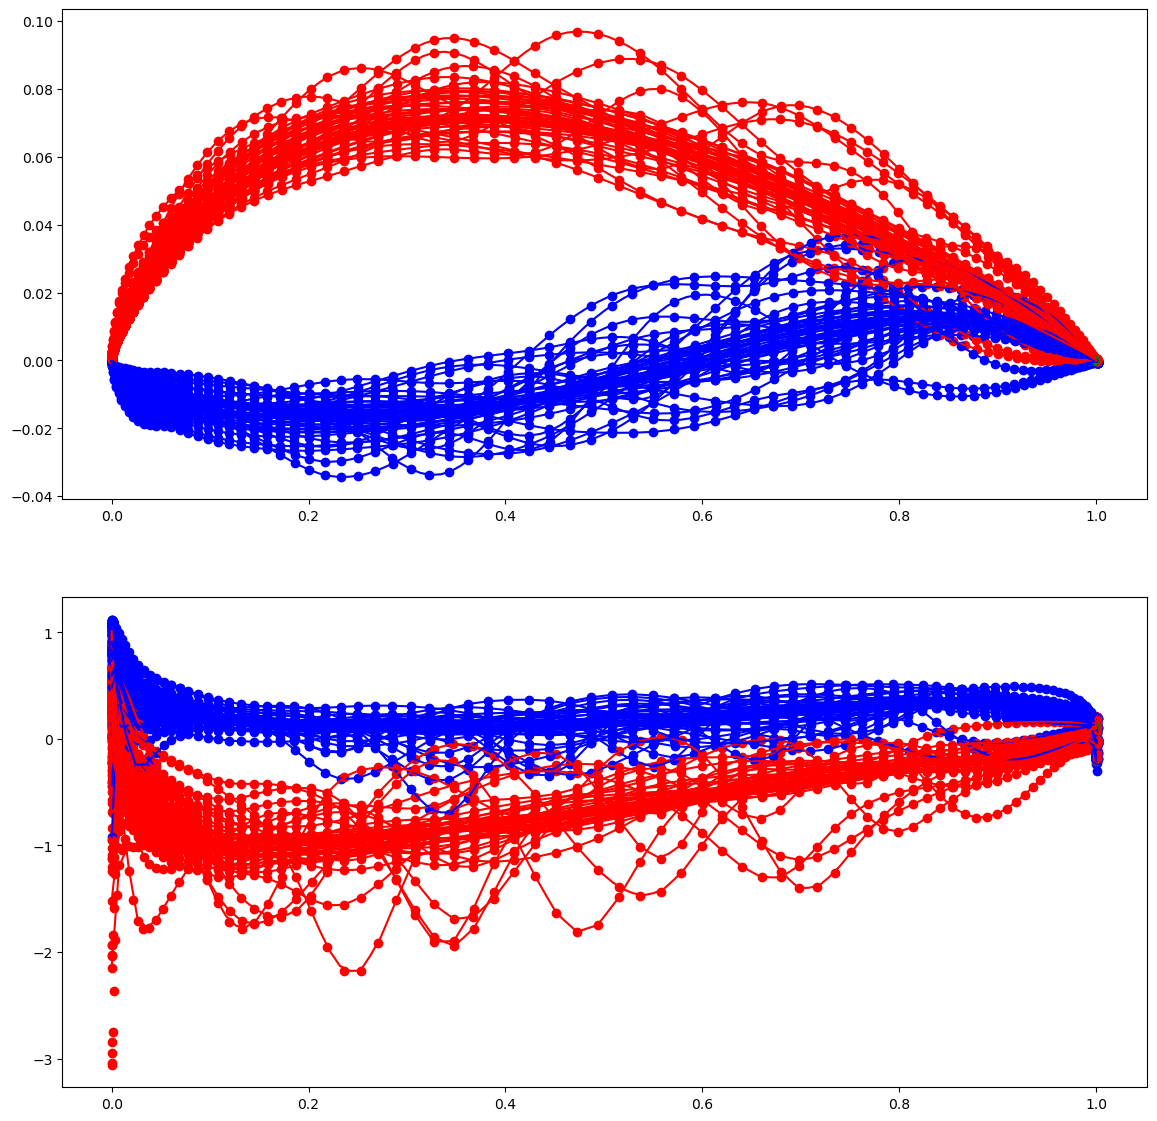

In [21]:
ns = 100
ndim = 2
nvar = 1
ndata = len(dataframes)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14,14))

geom_array = np.zeros((ndata, 2, ns, ndim))
field_array = np.zeros((ndata, 2, ns))

for i, df in enumerate(dataframes):
    # Fit raw spatial data to B-Splines
    x, y, cp = df['CoordinateX'].values, df['CoordinateY'].values, df['CP'].values
    xspline, yspline, s, xtip, ytip, idx_tip = fit_raw_Bspline(df)
    
    # Rotate and scale raw data
    x, y, xtip, ytip = rotate_scale(x, y, xtip, ytip)
    
    # Separate data (geometric and fluid) intp top and bottom components
    xyb, xyt, vb, vt, idx_tip = separate_top_bottom(x, y, cp, idx_tip)
    xb, yb, xt, yt = xyb[:,0], xyb[:,1], xyt[:,0], xyt[:,1]
    
    
    # Fit B-Spline to bottom processed coordinate/field data
    xysb, vsb, sb = spline_geom_field_fit(xyb, vb, ns)
    
    # Fit B-Spline to top processed coordinate/field data
    xyst, vst, st = spline_geom_field_fit(xyt, vt, ns)

    # Decompose x/y coordinates
    xsb, ysb, xst, yst = xysb[:,0], xysb[:,1], xyst[:,0], xyst[:,1]

    # Store geometry and field data
    geom_array[i,0,:,:], geom_array[i,1,:,:] =  xysb, xyst
    field_array[i,0,:], field_array[i,1,:] = vsb, vst
    
    # Geometry
    axs[0].scatter(xb, yb, c='b')
    axs[0].plot(xsb, ysb, c='b')
    axs[0].scatter(xt, yt, c='r')
    axs[0].plot(xst, yst, c='r')
    axs[0].scatter(xb[idx_tip], yb[idx_tip], c='g')
    
    # Field
    axs[1].scatter(xb, vb, c='b')
    axs[1].plot(xsb, vsb, c='b')
    axs[1].scatter(xt, vt, c='r')
    axs[1].plot(xst, vst, c='r')
    axs[1].scatter(xb[idx_tip], vb[idx_tip], c='g')

In [95]:
itarget = 0

distance_geometry = np.ones((ndata, ndata))*1e6
distance_field = np.ones((ndata, ndata))*1e6

for itarget in range(ndata):
    xytarget = geom_array[itarget,:,:,:]
    vtarget = field_array[itarget,:,:]
    
    for i in range(itarget+1,ndata):
        if i==itarget:
            distance_geometry[itarget, i] = 1e6
            distance_field[itarget, i] = 1e6
        else:
            xy = geom_array[i,:,:,:]
            v  = field_array[i,:,:]
    
            distance_geometry[itarget, i] = np.sum(np.sqrt(np.sum((xy - xytarget)**2, axis=1)))
            distance_field[itarget, i] = np.sum(np.sqrt(np.sum((v-vtarget)**2, axis=1)))

        if distance_geometry[itarget, i] < 5e-2:
            distance_geometry[itarget, i] = 1e6
            distance_field[itarget, i] = 1e6

print(distance_geometry.min())

0.050094470460303235


In [96]:
matrix = distance_field
indices_1d = np.argpartition(matrix, 3, axis=None)[:3]
indices_2d_field = np.unravel_index(indices_1d, matrix.shape)
least_three_field = matrix[indices_2d_field]

print('least three values : ', least_three_field)
print('indices : ', *zip(*indices_2d_field) )

least three values :  [0.72723159 0.78125221 0.79566352]
indices :  (10, 51) (10, 37) (2, 10)


In [97]:
matrix = distance_geometry
indices_1d = np.argpartition(matrix, 3, axis=None)[:3]
indices_2d_geometry = np.unravel_index(indices_1d, matrix.shape)
least_three_geometry = matrix[indices_2d_geometry]

print('least three values : ', least_three_geometry)
print('indices : ', *zip(*indices_2d_geometry) )

least three values :  [0.05044354 0.05027009 0.05009447]
indices :  (47, 53) (19, 30) (15, 43)


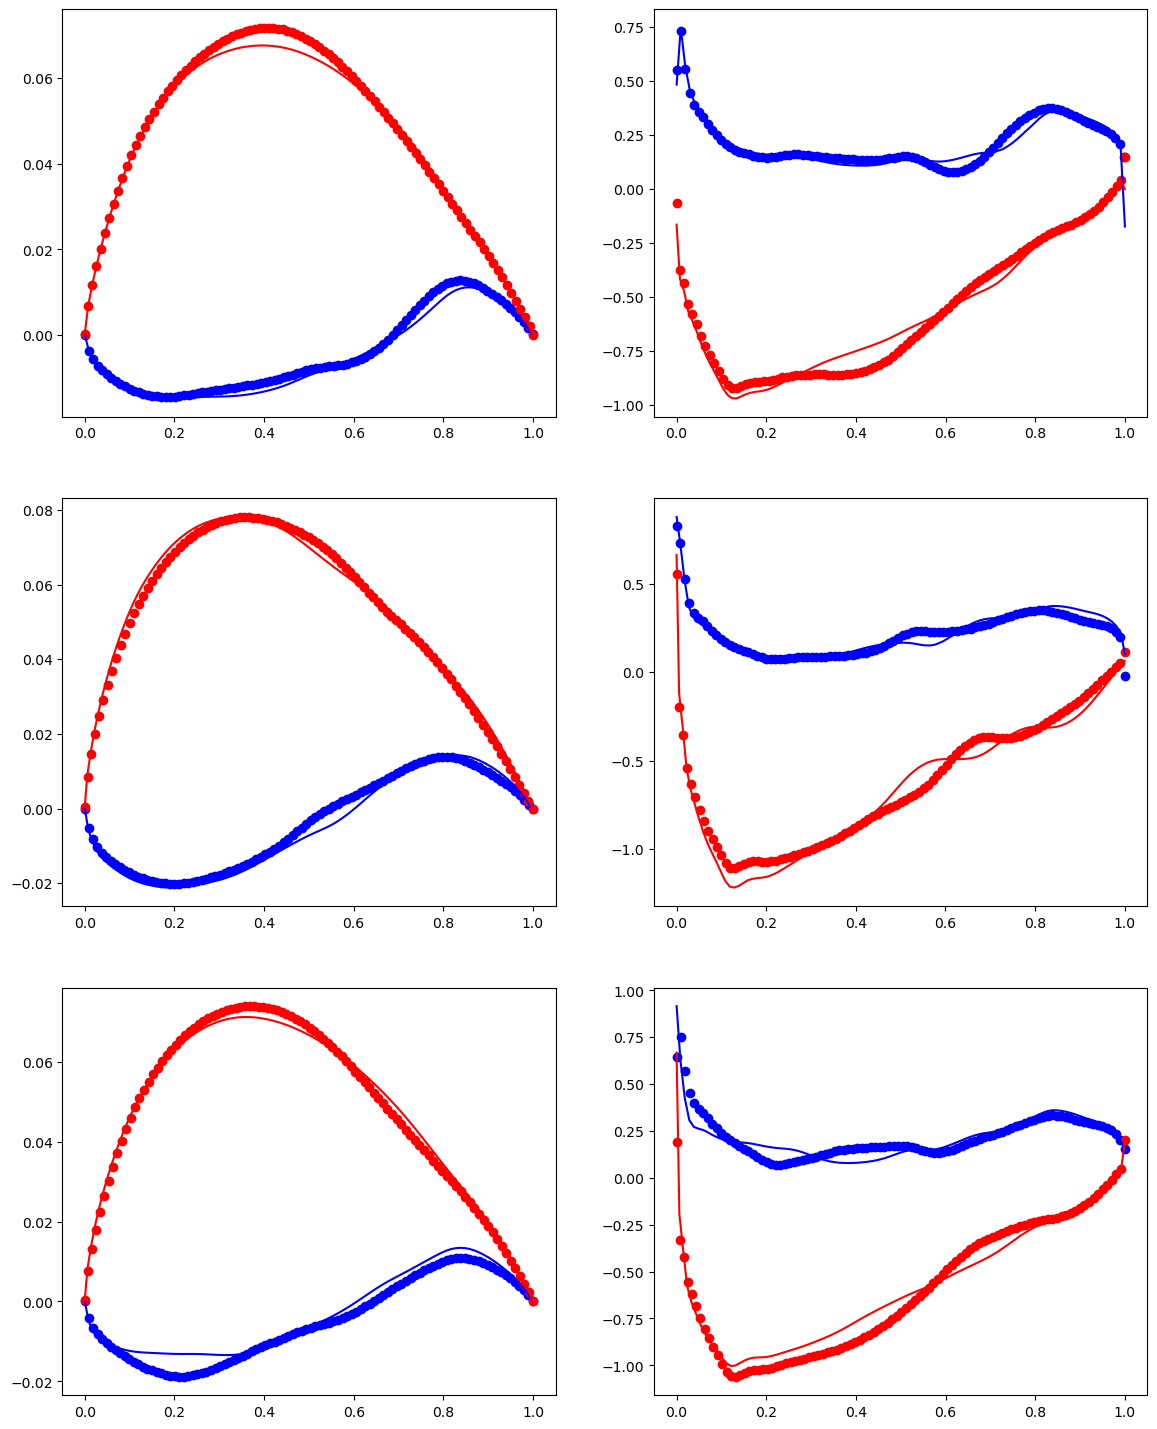

In [99]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,18))

for i in range(3):
    ix1, ix2 = indices_2d_geometry[0][i], indices_2d_geometry[1][i]
    iv1, iv2 = indices_2d_field[0][i], indices_2d_field[1][i]

    xytarget = geom_array[ix1,:,:,:]
    vtarget  = field_array[ix1,:,:]
    
    xy = geom_array[ix2,:,:,:]
    v  = field_array[ix2,:,:]

    axs[i,0].scatter(xytarget[0,:,0], xytarget[0,:,1], c='b')
    axs[i,0].plot(xy[0,:,0], xy[0,:,1], c='b')

    axs[i,0].scatter(xytarget[1,:,0], xytarget[1,:,1], c='r')
    axs[i,0].plot(xy[1,:,0], xy[1,:,1], c='r')

    axs[i,1].scatter(xytarget[0,:,0], vtarget[0,:], c='b')
    axs[i,1].plot(xy[0,:,0], v[0,:], c='b')

    axs[i,1].scatter(xytarget[1,:,0], vtarget[1,:], c='r')
    axs[i,1].plot(xy[1,:,0], v[1,:], c='r')

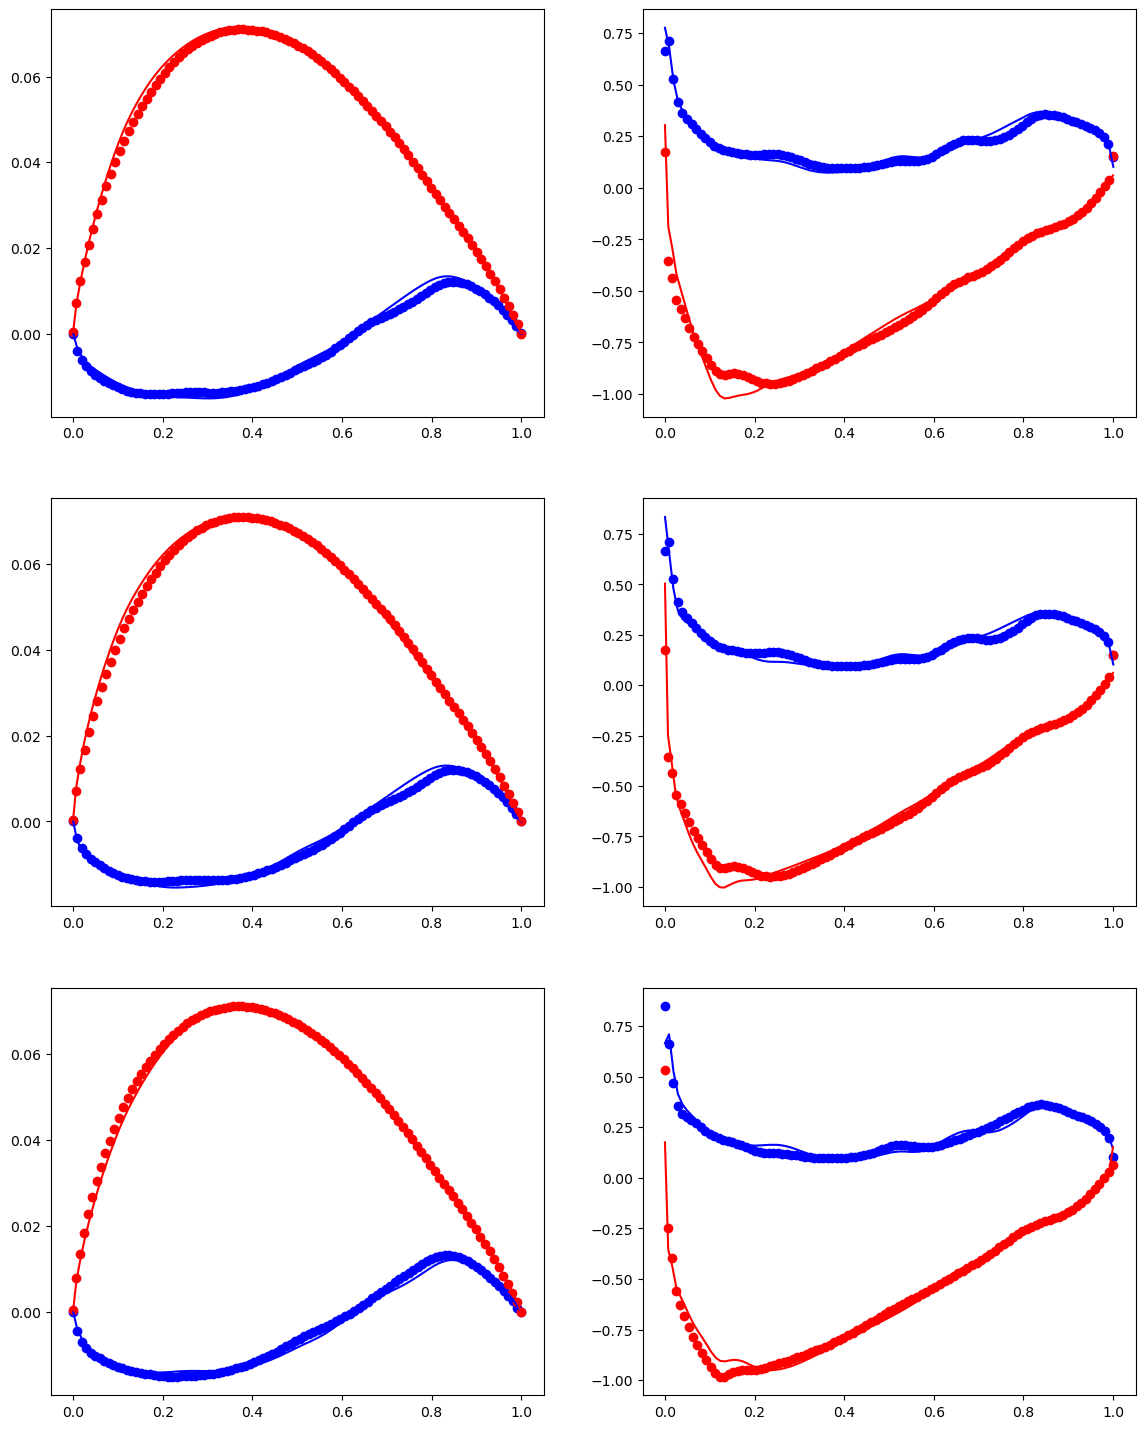

In [100]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,18))

for i in range(3):
    ix1, ix2 = indices_2d_geometry[0][i], indices_2d_geometry[1][i]
    iv1, iv2 = indices_2d_field[0][i], indices_2d_field[1][i]

    xytarget = geom_array[iv1,:,:,:]
    vtarget  = field_array[iv1,:,:]
    
    xy = geom_array[iv2,:,:,:]
    v  = field_array[iv2,:,:]

    axs[i,0].scatter(xytarget[0,:,0], xytarget[0,:,1], c='b')
    axs[i,0].plot(xy[0,:,0], xy[0,:,1], c='b')

    axs[i,0].scatter(xytarget[1,:,0], xytarget[1,:,1], c='r')
    axs[i,0].plot(xy[1,:,0], xy[1,:,1], c='r')

    axs[i,1].scatter(xytarget[0,:,0], vtarget[0,:], c='b')
    axs[i,1].plot(xy[0,:,0], v[0,:], c='b')

    axs[i,1].scatter(xytarget[1,:,0], vtarget[1,:], c='r')
    axs[i,1].plot(xy[1,:,0], v[1,:], c='r')